In [128]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Visualização de escoamento


### Mapa de calor
0 - azul

1 - vermelho

eixo x,y e z (plano)

### Mapa de resultados numeros com vetores de mesmo tamanho


### Resultados numeros com linhas de corrente
- linhas de corrente: linhas tangentes a velocidade (somatorio). linha de tangete a linha do vetor velocidade (trajetoria da particula do vetor da velocidade)

[ ] Implementação do programa e simulaçoes

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup 

In [129]:
class Setup:
    def __init__(self, params):

        #! Parametros JSON
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.SIZE_INDIVIDUAL = params["IND_SIZE"]
        self.TAXA_GENERATION = params["RCE_REPOPULATION_GENERATIONS"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )

        #! Parametros do algoritmo de Rastrigin
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * self.TAXA_GENERATION)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}

        #!Criando individuo pelo deap com seus atributos
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()

        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        # Variavel de decisão
        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)

        # registrando os individuos
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #! paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(
                self.rastrigin, x0=np.zeros(self.SIZE_INDIVIDUAL), method="BFGS"
            )
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("==========================================================================================")
        print(msg)
        print("==========================================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

## Algoritimo Evolutivo RCE

In [130]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.POPULATION)

        self.pop_RCE = []
        self.best_solutions_array = []
        self.best_individual_array = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def pesquisarLinear(self,array,num,pos=0):
        while ((pos < len(array)) and (array[pos] != num)):
            pos += 1

        if array[pos] == num:
            print("Valor encontrado")

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def checkClonesInPop(self, ind, new_pop):
        # Verificar se o indivíduo é um clone
        is_clone = False
        for other_ind in new_pop:
            if (
                ind == other_ind
                and sum(ind) == sum(other_ind)
                and ind.index != other_ind.index
            ):
                is_clone = True
                break
        return is_clone

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")

            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values[0],
                "RCE": ind.rce,
                "Diversidade": np.sum(ind),
            }

            # Adicionar a informação de clone ao dicionário
            is_clone = self.checkClonesInPop(ind, new_pop)
            ind_info["CLONE"] = "SIM" if is_clone else "NAO"

            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(40))

        # contar quantos SIM na coluna CLONE se a coluna RCE for SIM
        display(df[df["RCE"] != ""]["CLONE"].value_counts())

    def criterio1(self,new_pop):
        """Pega  30% do valor dos melhores fitness do HOF de cada geração."""
        self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")
        elite_size = int(0.3 * len(self.POPULATION))

        sorted_population = sorted(
            self.POPULATION, key=lambda x: x.fitness.values[0]
        )  # pop atual nao aleatória

        # Selecionar os 30% primeiros indivíduos (os de menor fitness)
        elite_individuals = sorted_population[:elite_size]

        # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
        for i, ind in enumerate(elite_individuals, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)             
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def criterio1_refatorado(self, new_pop, porcentagem, k= 30):
        """Seleciona os candidatos ao conjunto elite com base nas diferenças percentuais de aptidão."""
        self.cout(f"CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite")
        elite_individuals = []

        # Obter o melhor indivíduo (HOF) da população
        best_ind = new_pop[0]
        best_fitness = best_ind.fitness.values[0]

        # Ordenar a população em ordem crescente de aptidão e selecionar os k primeiros indivíduos
        sorted_population = sorted(self.POPULATION, key=lambda x: x.fitness.values[0])
        sorted_population = sorted_population[:k]
        max_difference = porcentagem * best_fitness

        # Selecionar com as menores diferenças percentuais

        for ind in sorted_population:
            fitness_difference = best_fitness - ind.fitness.values[0]
            # print(                f"Best: {round(max_difference,2)} x dif percentual: {round(fitness_difference,2)}"            )
            if fitness_difference <= max_difference:
                elite_individuals.append(ind)
            else:
                break  # Parar a seleção quando a diferença percentual for maior que o limite

        # Colocando na pop aleatória
        print(f"Calculando percentual de {porcentagem} com base no melhor fitness = {best_fitness} e pegando os {k} melhores.")
        for i, ind in enumerate(elite_individuals):
            new_pop[i] = self.setup.toolbox.clone(ind)             
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def aplicar_RCE(self, generation):
        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao

        # Avaliar o fitness da população atual
        self.avaliarFitnessIndividuos(self.POPULATION)
        self.calculateFitnessGeneration(self.POPULATION)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values} | Diversidade = {sum(pop[0])}") # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! critério 1 e obtém os N melhores com 30% do valor do melhor fitness
        #ind_selecionados = self.criterio1(new_pop)
        ind_selecionados = self.criterio1_refatorado(new_pop, 0.30, k = 30)
        # ind_array = self.generateInfoIndividual(new_pop, generation)
        # self.show_ind_df(ind_array, "Individuos da nova população aleatória")

        #! Critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        ind_diferentes_var = self.criterio2(ind_selecionados, delta=6) 
        print("Set conjunto Elite (sem clones) = ",len(self.CONJUNTO_ELITE_RCE))

        # preenche a pop com os selecionados do criterio 2
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[0].rce = "HOF"
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_2"

        #! Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        self.calculateFitnessGeneration(new_pop)
        self.cout(f"CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] ")
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")
        return new_pop

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.")
        self.pop_RCE = []
        self.CONJUNTO_ELITE_RCE.clear()

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                # print(f"Indivíduo VAR({current_individual})\n diferente! adicionado à nova população.")
                self.pop_RCE.append(current_individual)
                self.CONJUNTO_ELITE_RCE.add(tuple(current_individual))

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios. :( ")

        print("Tamanho Elite = ",len(self.pop_RCE))
        return self.pop_RCE

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def calculateFitnessGeneration(self, new_pop):
        # Calculando o fitness para geração
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                print("")
                self.cout(
                    f"RCE being applied! - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(current_generation + 1)
                print("\nPopulação gerada pelo RCE\n", new_population)
                self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

## Exemplo de uso

### Codigo de usuario

In [131]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "




	 RCE being applied! - Generation = 20 

Elitismo HOF Index[0] [0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 4.7231380789284065] 
 Fitness = (6.864772117691526,) | Diversidade = 5.255940759355834

	 CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite

Calculando percentual de 0.3 com base no melhor fitness = 6.864772117691526 e pegando os 30 melhores.

	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Nenhum indivíduo atende aos critérios. :( 
Tamanho Elite =  0
Set conjunto Elite (sem clones) =  0

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,20,0,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,5.255941,NAO
1,20,1,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,4.213615,SIM
2,20,2,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,5.255941,SIM
3,20,3,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,6.959090,NAO
4,20,4,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,2.382780,NAO
5,20,5,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,0.679631,SIM
6,20,6,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,4.213615,SIM
7,20,7,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,7.308116,SIM
8,20,8,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,5.029525,NAO
9,20,9,"[0.02434927946898746, 1.1245878324090315, -0.9...",6.864772,SIM_1,4.213615,SIM


CLONE
SIM    23
NAO     7
Name: count, dtype: int64


População gerada pelo RCE
 [[0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, 0.8333114535925779, -4.210578396348643, 4.7231380789284065], [0.02434927946898746, 1.1245878324090315, -0.97557748775455, 0.9450127671368742, -0.009738104303510173, -1.0636656505192414, 2.0342657323862543, 0.83331

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,40,0,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,HOF,5.225046,NAO
1,40,1,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,3.327957,NAO
2,40,2,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,5.053557,SIM
3,40,3,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,6.063407,SIM
4,40,4,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,6.860132,SIM
5,40,5,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,6.860132,SIM
6,40,6,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,6.063407,SIM
7,40,7,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,8.326589,SIM
8,40,8,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,2.114143,SIM
9,40,9,"[-0.006667051370386368, 0.8850198105833068, 0....",3.540090,SIM_2,6.860132,SIM


CLONE
SIM    25
NAO     5
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, -0.9051486696529052, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [-0.006667051370386368, 0.8850198105833068, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 2.470318563100129, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [-0.006667051370386368, 0.8850198105833068, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.8850198105833068, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,60,0,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,HOF,5.225046,SIM
1,60,1,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,6.703387,NAO
2,60,2,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,-3.230601,SIM
3,60,3,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,2.285631,NAO
4,60,4,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,4.035035,NAO
5,60,5,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,-3.230601,SIM
6,60,6,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,3.172870,NAO
7,60,7,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,4.215196,SIM
8,60,8,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,5.225046,SIM
9,60,9,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_2,5.225046,SIM


CLONE
SIM    16
NAO    14
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.470280952882442, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, -4.77483417519848], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, -0.9051486696529052, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 6.27189

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,80,0,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,5.225046,SIM
1,80,1,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,4.979445,NAO
2,80,2,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,6.267372,SIM
3,80,3,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,10.954390,NAO
4,80,4,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,9.208683,NAO
5,80,5,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,2.285631,SIM
6,80,6,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,5.225046,SIM
7,80,7,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,3.327957,SIM
8,80,8,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,-1.546270,NAO
9,80,9,"[-0.006667051370386368, 0.046658649760982995, ...",0.687601,SIM_1,2.285631,SIM


CLONE
SIM    15
NAO    15
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 1.7886647717576896, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -4.210578396348643, 4.7231380789284065], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.52249417113427, 2.0342657323862543, -0.8698375056671459, -0.22694122627541002, 5.426519310098], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.009738104303510173, 4.522494

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,100,0,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,HOF,10.575917,SIM
1,100,1,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,10.575917,SIM
2,100,2,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,2.291959,NAO
3,100,3,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,10.575917,SIM
4,100,4,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,6.275596,SIM
5,100,5,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,4.037666,SIM
6,100,6,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,2.443695,SIM
7,100,7,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,8.021303,SIM
8,100,8,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,8.021303,SIM
9,100,9,"[-0.006667051370386368, 0.046658649760982995, ...",0.671100,SIM_2,3.085656,NAO


CLONE
SIM    22
NAO     8
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.0034104279984710564, 4.52249417113427, 1.6494645523284612, -0.8698375056671459, -0.22694122627541002, 5.426519310098], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.0034104279984710564, 4.52249417113427, 1.6494645523284612, -0.8698375056671459, -0.22694122627541002, 5.426519310098], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.0034104279984710564, 4.52249417113427, -0.9051486696529052, -0.8698375056671459, -4.210578396348643, 3.6808122062278636], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.0034104279984710564, 4.52249417113427, 1.6494645523284612, -0.8698375056671459, -0.22694122627541002, 5.426519310098], [-0.006667051370386368, 0.046658649760982995, 0.03400348703581457, 0.0036325538143580144, -0.0034104279984710564, 4.5224

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[-1.1093671110867458, 1.1245878324090315, -1.0...","(32.26994149570497,)",108.401488,0.0,-
1,1,1,"[-0.6338143034322696, -1.5883402536378504, -2....","(100.92894687028982,)",108.401488,0.0,-
2,1,2,"[0.8595828673822572, -1.1129899401871546, -2.6...","(89.51441835424644,)",108.401488,0.0,-
3,1,3,"[3.8840552236187103, -4.780741273257177, -0.61...","(76.42703581628994,)",108.401488,0.0,-
4,1,4,"[3.3463129493073582, -0.3915707145178624, -4.5...","(107.57902976625023,)",108.401488,0.0,-
...,...,...,...,...,...,...,...
9995,100,95,"[-2.967474863817248, 3.1546310271198488, 4.202...","(84.37259505882223,)",101.958406,0.0,-
9996,100,96,"[2.7966180238330285, 4.74962032950413, 0.61090...","(100.19213384195591,)",101.958406,0.0,-
9997,100,97,"[-3.496700695618779, -1.942021693951649, 1.582...","(91.0077457543521,)",101.958406,0.0,-
9998,100,98,"[1.500310951844929, 0.38943593821008715, 0.213...","(97.76880639490149,)",101.958406,0.0,-



	 VISUALIZANDO OS RESULTADOS



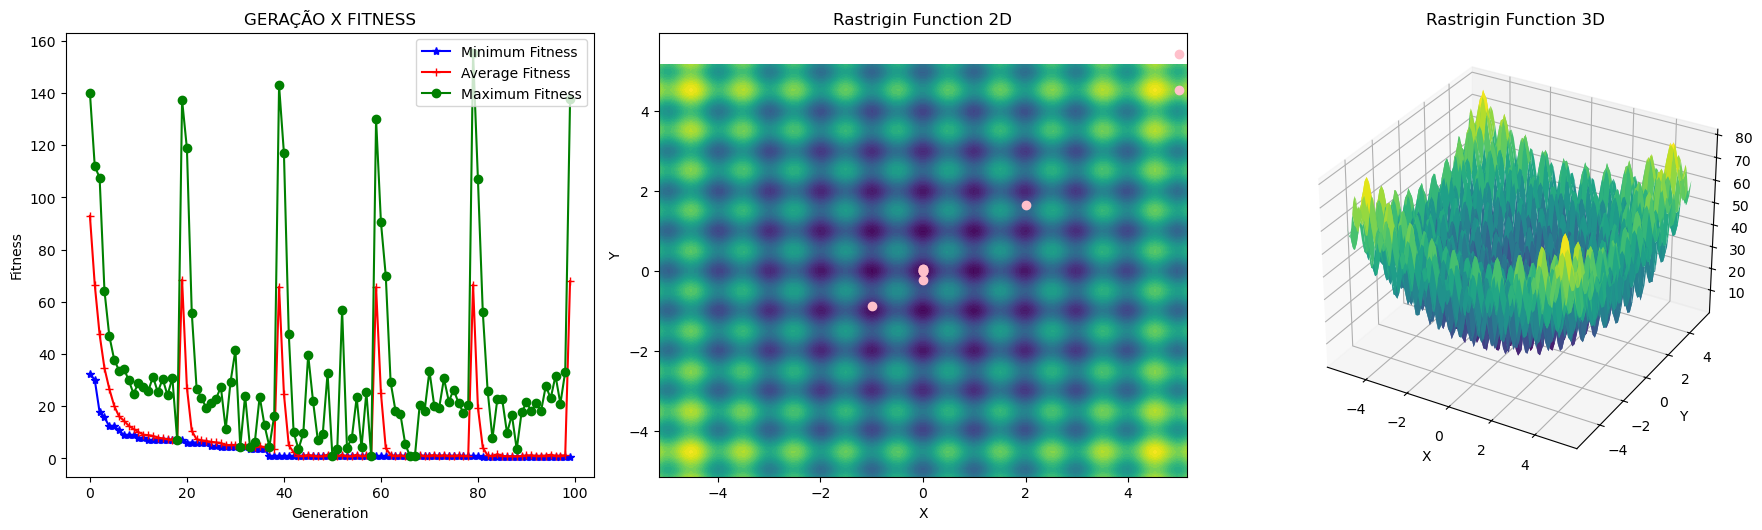

Soluções do problema

Best solution index =  81

Best solution variables =
 [-4.160236591449112, -2.2234946824514057, -2.3951949822755445, -4.511880195057961, -4.055334105633352, 2.948385507891552, 1.9422987015127582, 4.58164707740329, 2.895421339234235, -1.2830785741214448]

Best solution fitness =  0.6711002644756849

Ótimo global da função Rastrigin =  112.42958856591598

Solução ótima global =  [-3.97978397 -1.98991256 -1.98991239 -4.97469105 -3.97978387  2.98485514
  1.9899121   4.97469088  2.98485576 -0.9949584 ]

Porcentagem de proximidade da solução em relação ao ótimo global =  99.4030928396734 %

Distância da solução em relação ao ótimo global = <built-in function abs>


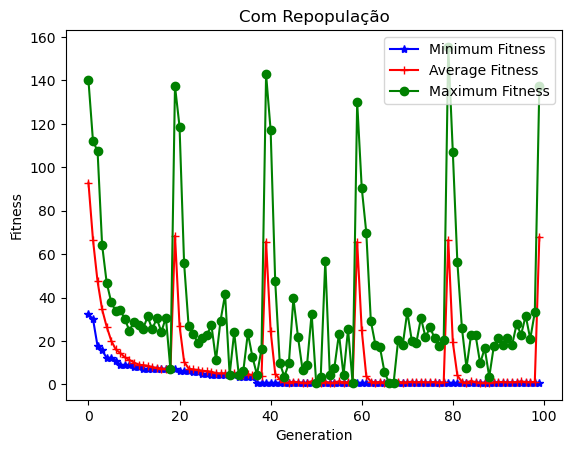

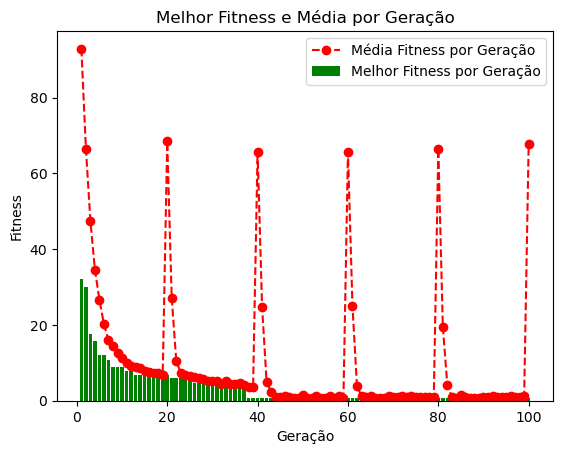

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,32.269941,92.944463,140.092800,23.130570
1,1,30.056379,66.513239,111.937146,21.974130
2,2,17.638953,47.443924,107.528850,16.718814
3,3,15.684580,34.534516,64.191527,9.708940
4,4,12.199593,26.599377,46.879274,8.556278
...,...,...,...,...,...
95,95,0.671100,1.367320,22.929298,3.394200
96,96,0.671100,0.988672,31.655776,3.083118
97,97,0.671100,1.064124,20.912994,2.458200
98,98,0.671100,1.143329,33.184975,3.537241


Total execution time: 2.97 seconds


In [132]:
from src.models.AlgEvolution import AlgEvolution

def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()
    # old_alg = AlgEvolution(setup)

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )

    print("\n\nEvolução concluída  - 100%")

    # Salvar resultados
    alg.cout("---> RESULTADOS OBTIDOS")
    data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "Todos Individuos Gerados")
    # data_visual.show_conjuntoElite(alg.pop_RCE)


    # Visualização dos resultados
    alg.cout("VISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")